In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023

In [2]:
# pv 24h + 28 weather features(5 temp, 3 precip, 5 prob_precip, 5 humid, 5 wind speed, 5 sky)

pv_features = pd.read_csv('./processed_data/pv_forecastweather_feature.csv')
pv_features = pv_features.rename(columns={'Unnamed: 0':'date'}).set_index('date', drop=True)
pv_features_length = len(pv_features)

pv_features.index = [str(idx) for idx in pv_features.index]

# X: 52 features, Y: 24 features
X = pv_features.iloc[0:pv_features_length-1].copy(deep=True)
Y = pv_features.iloc[1:pv_features_length][['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']].copy(deep=True)  # X and Y should be divided completely, so Y get deeply copied.

In [3]:
pv_features.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'TM_6', 'TM_9', 'TM_12', 'TM_15', 'TM_18', 'PR_9', 'PR_15', 'PR_21',
       'PP_6', 'PP_9', 'PP_12', 'PP_15', 'PP_18', 'HM_6', 'HM_9', 'HM_12',
       'HM_15', 'HM_18', 'WS_6', 'WS_9', 'WS_12', 'WS_15', 'WS_18', 'SK_6',
       'SK_9', 'SK_12', 'SK_5', 'SK_18'],
      dtype='object')

In [4]:
X

,0,1,2,3,4,5,6,7,8,9,...,WS_6,WS_9,WS_12,WS_15,WS_18,SK_6,SK_9,SK_12,SK_5,SK_18
210104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,104.2,...,6.1,3.3,2.7,2.1,2.8,4.0,4.0,4.0,4.0,4.0
210105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1,69.4,...,2.4,1.1,2.5,6.0,6.6,4.0,4.0,4.0,4.0,4.0
210106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,48.2,...,6.5,4.3,2.3,2.1,2.9,4.0,4.0,4.0,4.0,4.0
210107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,3.7,1.3,1.3,1.6,2.2,4.0,1.0,1.0,3.0,4.0
210108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1.1,...,4.7,4.9,1.9,1.3,1.5,3.0,4.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,86.1,...,3.0,2.0,2.3,2.5,2.8,1.0,1.0,1.0,1.0,1.0
211221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,101.3,...,2.7,1.5,1.4,1.4,1.9,1.0,1.0,1.0,1.0,1.0
211227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,161.1,...,2.6,1.3,1.1,1.4,1.2,4.0,4.0,4.0,4.0,4.0
211228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,73.7,...,4.7,2.0,3.2,2.8,3.0,4.0,4.0,4.0,4.0,4.0


In [5]:
Y

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
210105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1,69.4,...,282.5,107.3,79.0,15.4,0.0,0.0,0.0,0.0,0.0,0.0
210106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,48.2,...,487.7,361.1,232.6,7.4,0.0,0.0,0.0,0.0,0.0,0.0
210107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,2.9,1.6,0.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0
210108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1.1,...,4.7,17.1,9.2,0.8,0.0,0.0,0.0,0.0,0.0,0.0
210111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,62.2,...,139.6,99.2,61.2,12.4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,101.3,...,374.7,299.6,130.9,9.6,0.0,0.0,0.0,0.0,0.0,0.0
211227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,161.1,...,286.6,57.4,37.5,2.2,0.0,0.0,0.0,0.0,0.0,0.0
211228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,73.7,...,88.7,63.8,15.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0
211229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.6,68.2,...,64.0,54.3,176.4,9.6,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def plotYear(data, ylabel):
    label_interval = [18, 17, 22, 21, 19, 15, 22, 21, 21, 19, 21, 18]
    data = data

    # Create figure and plot the data
    fig = plt.figure(figsize=(10,2.5))
    ax = plt.axes()
    ax.plot(data)

    plt.title('Original Data X')
    plt.xlabel('Month', fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # Set the x-tick positions and labels
    x_ticks = []
    x_labels = []
    for i, interval in enumerate(label_interval):
        # start = sum(label_interval[:i])*24
        start = sum(label_interval[:i])
        x_ticks.append(start)
        x_labels.append(f'{i+1}')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)


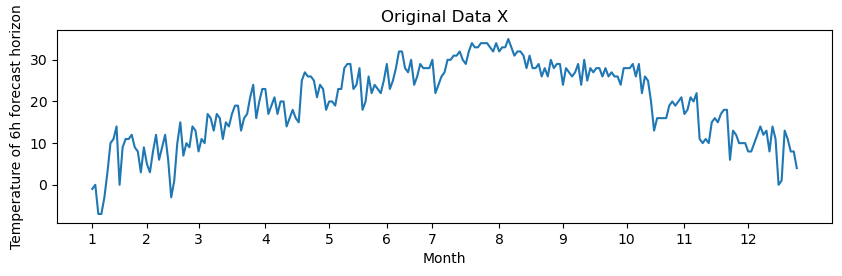

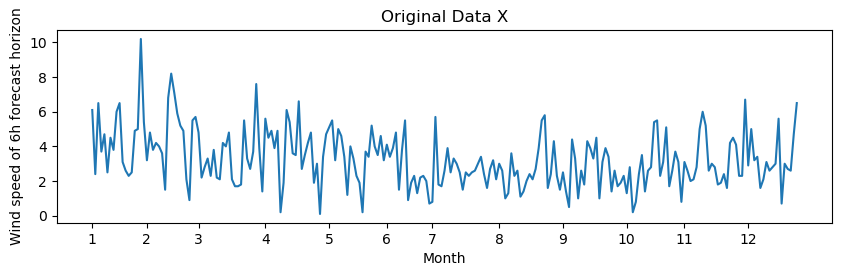

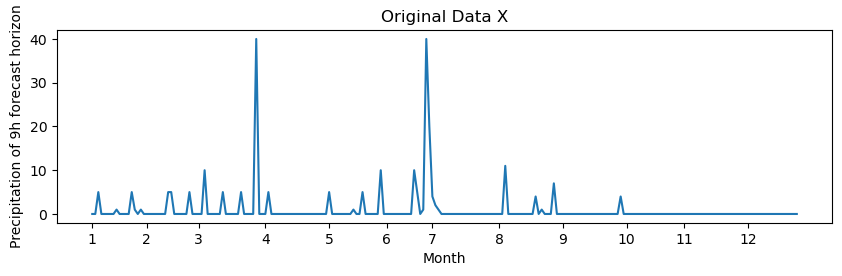

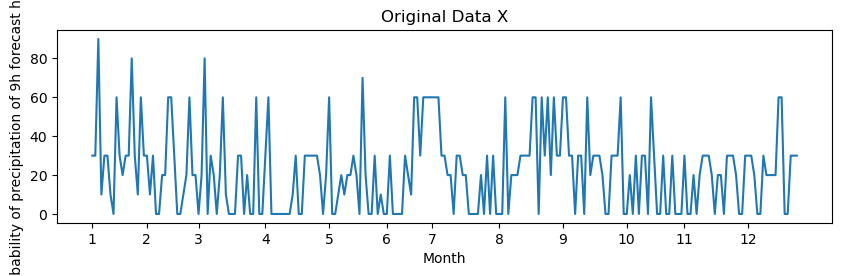

In [7]:
plotYear(X[['TM_6']], 'Temperature of 6h forecast horizon')
plotYear(X[['WS_6']], 'Wind speed of 6h forecast horizon')
plotYear(X[['PR_9']], 'Precipitation of 9h forecast horizon')
plotYear(X[['PP_9']], 'Probability of precipitation of 9h forecast horizon')

In [8]:
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)

In [9]:
dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()

In [10]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



# load forecast model에서 사용한 dataset 기간과 동일하게 설정
train_size = 186
mini_train_size = 148

train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [11]:
# same as model.ipynb
def train(model, trian_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(trian_dataloader.dataset)).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [12]:
X.shape

torch.Size([233, 52])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(52, 64)
        self.fc2 = nn.Linear(64, 512)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(512, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(512)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output
    

In [14]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 50000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        # torch.save(model.state_dict(), './model.pt')
        # print('state_dict format of the model:\n{}'.format(model.state_dict()))
    if epoch % 1000 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/50000  |  Train Loss 2111.465088  |  Val Loss 36358.574219
Train Epoch: 1000/50000  |  Train Loss 231.229782  |  Val Loss 5109.123047
Train Epoch: 2000/50000  |  Train Loss 128.600739  |  Val Loss 2987.921143
Train Epoch: 3000/50000  |  Train Loss 102.243507  |  Val Loss 2131.952393
Train Epoch: 4000/50000  |  Train Loss 76.043999  |  Val Loss 1536.472778
Train Epoch: 5000/50000  |  Train Loss 57.133327  |  Val Loss 1078.591675
Train Epoch: 6000/50000  |  Train Loss 54.418953  |  Val Loss 763.468628
Train Epoch: 7000/50000  |  Train Loss 39.852600  |  Val Loss 561.413574
Train Epoch: 8000/50000  |  Train Loss 29.151489  |  Val Loss 406.873657
Train Epoch: 9000/50000  |  Train Loss 29.567532  |  Val Loss 309.975403
Train Epoch: 10000/50000  |  Train Loss 29.646860  |  Val Loss 254.326233
Train Epoch: 11000/50000  |  Train Loss 24.172773  |  Val Loss 183.161942
Train Epoch: 12000/50000  |  Train Loss 26.160517  |  Val Loss 164.446182
Train Epoch: 13000/50000  |  Train L

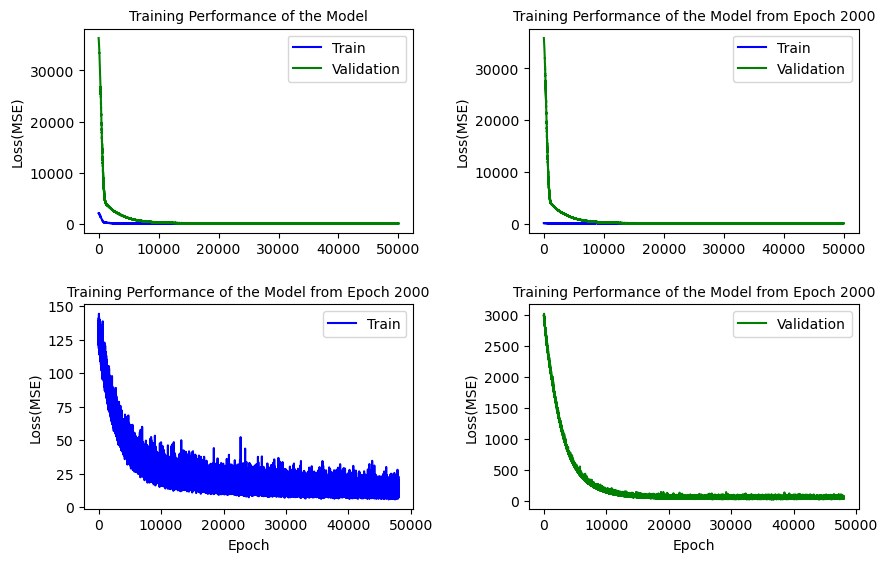

In [16]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[2000:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[2000:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[2000:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

In [17]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_512_BN_20000_50000.pt')

In [18]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

Train Epoch:    0/38712  |  Train Loss 5.647034
Train Epoch:  200/38712  |  Train Loss 11.492585
Train Epoch:  400/38712  |  Train Loss 6.873713
Train Epoch:  600/38712  |  Train Loss 9.203457
Train Epoch:  800/38712  |  Train Loss 7.591199
Train Epoch: 1000/38712  |  Train Loss 8.868201
Train Epoch: 1200/38712  |  Train Loss 9.331944
Train Epoch: 1400/38712  |  Train Loss 12.636481
Train Epoch: 1600/38712  |  Train Loss 11.201957
Train Epoch: 1800/38712  |  Train Loss 6.905919
Train Epoch: 2000/38712  |  Train Loss 10.161868
Train Epoch: 2200/38712  |  Train Loss 6.865285
Train Epoch: 2400/38712  |  Train Loss 9.206508
Train Epoch: 2600/38712  |  Train Loss 6.905046
Train Epoch: 2800/38712  |  Train Loss 15.582983
Train Epoch: 3000/38712  |  Train Loss 9.867957
Train Epoch: 3200/38712  |  Train Loss 9.829383
Train Epoch: 3400/38712  |  Train Loss 7.886958
Train Epoch: 3600/38712  |  Train Loss 11.913649
Train Epoch: 3800/38712  |  Train Loss 9.803486
Train Epoch: 4000/38712  |  Train 

In [19]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_512_BN_50000_train.pt')

In [20]:
test_output, test_y = evaluate(model, test_dataloader)

# 6~20시에만 PV 발전량 존재. PV 발전량 음수는 안 나온다.
test_output = torch.where(test_output > 0, test_output, 0)  # 새롭게 추가된 코드!
test_output[:,0:6] = 0
test_output[:, 21:] = 0


test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
# test_mape = mape(test_output, test_y)


# TODO: MAPE 나타내보기.. 일부 값들만 선택해서!
print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
# print('MAPE(%): {:.6f}'.format(test_mape*100))  # 실제 정답값에 0이 포함되기 때문에 계산 불가능

Test Loss
MSE: 11524.165039
MAE: 54.900784


In [21]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    ax = plt.axes()
    plt.title('Actual and forecast PV generation for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Net-load', fontsize = 15)
    x_ticks = range(0,length*24, 24)
    x_labels = range(0, length)
    ax.set_xticks(x_ticks, x_labels)
    plt.plot(Y.detach().numpy()[i:i+(length*24),:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+(length*24),:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


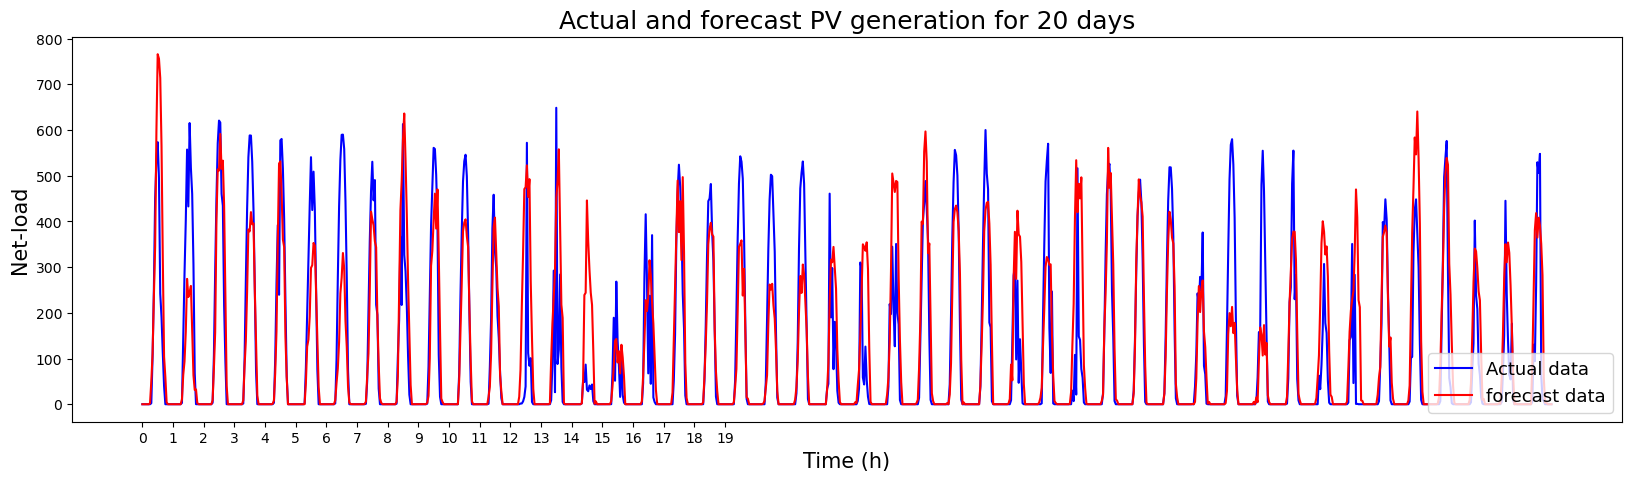

In [22]:
# 211020 ~ 211117
plot(1, 20, test_output, test_y)